In [1]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(14)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y 

In [4]:
total_bandwidth = 100e6 # [Hz]
tx_power = 1 # [W]

environment_constant = 1e-4
pathloss_constant = 4

ref_distance = 1 # [m]

In [5]:
def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions

In [6]:
def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')

In [7]:
def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.sqrt(((ue_pos[ue])[0] - (ap_pos[ap])[0])**2
                          + ((ue_pos[ue])[1] - (ap_pos[ap])[1])**2)

            if dis >= ref_distance:
                dis_matrix[ue, ap] = dis
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [8]:
def shadowing(std, num_ue, num_ap):

    return np.random.lognormal(sigma = std, size = (num_ue, num_ap))

In [9]:
def rayleigh(std, num_ue, num_ap):

    return np.sqrt((std*np.random.randn(num_ue, num_ap))**2 + (std*np.random.randn(num_ue, num_ap))**2) 

In [10]:
def pathloss_channel(distance):

    return (environment_constant / (distance ** pathloss_constant))

In [11]:
def shadowing_channel(distance, shadowing):

    return shadowing * (environment_constant / (distance ** pathloss_constant))

In [12]:
def multipath_channel(distance, shadowing, rayleigh):

    return shadowing * (environment_constant / (distance ** pathloss_constant)) * rayleigh**2

In [28]:
def rx_power(channel, tx_power):
    
    power_vector = np.zeros(channel.shape)
    
    for ue in range(channel.shape[0]):

        max_index = np.where(channel[ue, :] == channel[ue, :].max())
        power_vector[ue][max_index] = tx_power[ue] * channel[ue, :].max()
        
    return power_vector

In [33]:
def sinr(power_vector, power_noise):
    
    sinr_array = np.zeros(power_vector.shape[0])

    for p in range(power_vector.shape[1]):

        power_sum = sum(power_vector[:, p])
    
        for power in range(power_vector.shape[0]):

            if power_vector[power][p] != 0:
        
                sinr_array[power] = (power_vector[power][p]) / ((power_sum - power_vector[power][p]) + power_noise)
        
    return lin2db(sinr_array)

In [35]:
def capacity(total_bandwidth, sinr):
    
    return (total_bandwidth * np.log2(1 + db2lin(sinr))) / 1e6

In [36]:
def power_noise(total_bandwidth):
    
    return total_bandwidth * 1e-20

In [40]:
num_ue = 13
num_ap = 64
cov_side = 1000 # [m]
seeds = 1000

sh_std = 2
mp_std = 1 / np.sqrt(2) 

noise_p = power_noise(total_bandwidth)

In [41]:
total_sinr_pl = np.zeros((num_ue, seeds))
total_sinr_sh = np.zeros((num_ue, seeds))
total_sinr_mp = np.zeros((num_ue, seeds))

total_capacity_pl = np.zeros((num_ue, seeds))
total_capacity_sh = np.zeros((num_ue, seeds))
total_capacity_mp = np.zeros((num_ue, seeds))

for seed in range(seeds):
    
    ue_pos = random_ue_positions(num_ue, cov_side)
    ap_pos = ap_positions(num_ap, cov_side)
    distances = distance(ue_pos, ap_pos)
    
    shadowing_matrix = shadowing(sh_std, num_ue, num_ap)
    rayleigh_matrix = rayleigh(mp_std, num_ue, num_ap)
    
    pl_matrix = pathloss_channel(distances)
    sh_matrix = shadowing_channel(distances, shadowing_matrix)
    mp_matrix = multipath_channel(distances, shadowing_matrix, rayleigh_matrix)
    
    pl_power = rx_power(pl_matrix, tx_power)
    sh_power = rx_power(sh_matrix, tx_power)
    mp_power = rx_power(mp_matrix, tx_power)
    
    total_sinr_pl[:, seed] = sinr(pl_power, noise_p)
    total_sinr_sh[:, seed] = sinr(sh_power, noise_p)
    total_sinr_mp[:, seed] = sinr(mp_power, noise_p)
    
    total_capacity_pl[:, seed] = capacity(total_bandwidth, sinr(pl_power, noise_p))
    total_capacity_sh[:, seed] = capacity(total_bandwidth, sinr(sh_power, noise_p))
    total_capacity_mp[:, seed] = capacity(total_bandwidth, sinr(mp_power, noise_p))

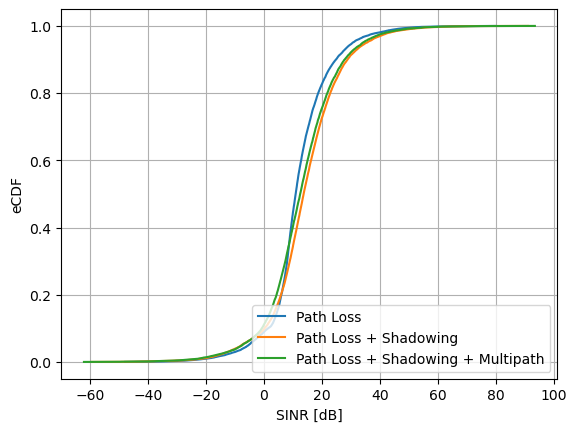

In [42]:
sinr_cdf_pl = eCDF(total_sinr_pl.flatten())
plt.plot(sinr_cdf_pl[0], sinr_cdf_pl[1], label='Path Loss')

sinr_cdf_sh = eCDF(total_sinr_sh.flatten())
plt.plot(sinr_cdf_sh[0], sinr_cdf_sh[1], label='Path Loss + Shadowing')

sinr_cdf_mp = eCDF(total_sinr_mp.flatten())
plt.plot(sinr_cdf_mp[0], sinr_cdf_mp[1], label='Path Loss + Shadowing + Multipath')

plt.xlabel('SINR [dB]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()

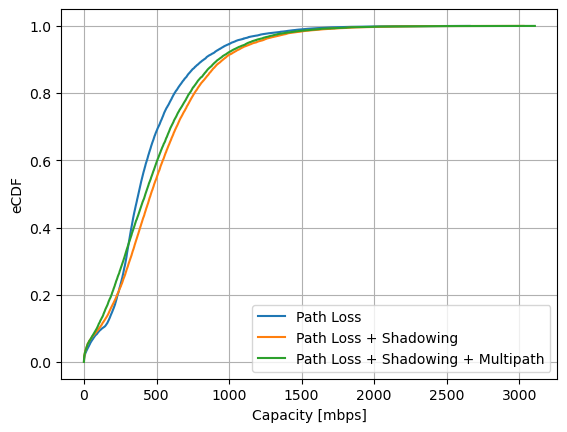

In [44]:
capacity_cdf_pl = eCDF(total_capacity_pl.flatten())
plt.plot(capacity_cdf_pl[0], capacity_cdf_pl[1], label='Path Loss')

capacity_cdf_sh = eCDF(total_capacity_sh.flatten())
plt.plot(capacity_cdf_sh[0], capacity_cdf_sh[1], label='Path Loss + Shadowing')

capacity_cdf_mp = eCDF(total_capacity_mp.flatten())
plt.plot(capacity_cdf_mp[0], capacity_cdf_mp[1], label='Path Loss + Shadowing + Multipath')

plt.xlabel('Capacity [mbps]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()